# Thesis: Quantitative Assessment of Alternative Reinsurance for the Catastrophes Risks in Russian Regions
## Oleg Pryanikov BEC204
## Moscow 2024

In [2]:
import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn 
from scipy.stats import poisson
import statsmodels.api as sm
from numpy import random as rn
from scipy import stats
from fitter import Fitter, get_common_distributions
from scipy.stats import weibull_max
from tqdm import tqdm
from scipy.integrate import quad
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Interest rate process

In [3]:
short_rates = pd.read_csv('short_rates.csv', sep=';', decimal=',')
short_rates[:2506]

,tradedate,tradetime,period_0.25
0,06.01.2014,12:21:16,5.92
1,08.01.2014,12:41:22,5.92
2,09.01.2014,18:38:19,5.78
3,10.01.2014,18:38:17,5.70
4,13.01.2014,18:37:26,5.81
...,...,...,...
2501,25.12.2023,18:39:59,13.78
2502,26.12.2023,18:39:59,13.33
2503,27.12.2023,18:39:57,13.22
2504,28.12.2023,18:39:57,12.78


Time interval: δt=0.08333333333333333 years
Simulation path M=1000000


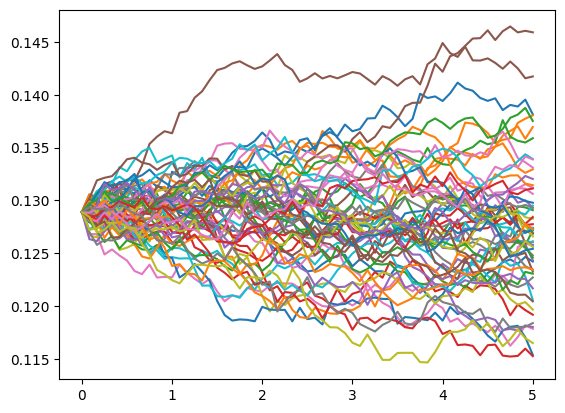

The expected value for the interest rate is: 12.770%
The standard error of sample mean is: 0.0006%
Lower 99% is: 12.768%
Upper 99% is: 12.772%


In [4]:
'''Parameters a, b, σ for Cox-Ingersoll-Ross colibrated in excel: CIR_Calibration.xlsx'''

a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = T/N
print(f"Time interval: δt={δt} years")
M = 1000000
print(f"Simulation path M={M}")
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))
for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)
plt.show()

a = [ rn.randint(0,M) for j in range(1,60)]

for runer in a:
    plt.plot(np.arange(0,T+δt,δt),r[runer])
plt.show()
V = (r[:,-1])
print("The expected value for the interest rate is:","{:.3%}".format(np.mean(V)))
print("The standard error of sample mean is:", "{:.4%}".format(np.std(V)/np.sqrt(M)))
from scipy.stats import norm
def normsinv(x):
    x = norm.ppf(x)
    return (x)

z = normsinv(0.995)
μ = np.mean(V)
SE = np.std(V)/np.sqrt(M)

print("Lower 99% is:","{:.3%}".format( (μ-z*SE) ))
print("Upper 99% is:","{:.3%}".format( (μ+z*SE) ))

In [5]:
a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = 0.08333333333333333
M = 1000000
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))

for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)

rate = []
years = []
for i in range(0,61):
    rate.append(np.mean(r[:,i]))
    years.append(i/12)

In [6]:
rate

[0.12889999999999982,
 0.12887844553989736,
 0.12885930690299136,
 0.12883997158700736,
 0.1288194959058528,
 0.1287981726035983,
 0.12877780404262493,
 0.12875704477918,
 0.12873732742493282,
 0.12871608429874437,
 0.12869604423829148,
 0.1286757260010704,
 0.12865550981878618,
 0.12863563301554895,
 0.12861495408125523,
 0.1285950445657497,
 0.1285746528390358,
 0.12855420767587766,
 0.1285344071400114,
 0.128516118687458,
 0.12849607641212585,
 0.12847446568183568,
 0.12845441920043812,
 0.12843392207562676,
 0.12841320330844747,
 0.1283937415837932,
 0.12837338795070335,
 0.12835274515807632,
 0.128332948304992,
 0.12831314762308937,
 0.1282923880612206,
 0.12827214353162703,
 0.12825288508114735,
 0.12823007346700535,
 0.12820997708806983,
 0.12819129663780987,
 0.12816977152913417,
 0.12814960950155618,
 0.12812994356542678,
 0.12810977696167733,
 0.1280877451913415,
 0.12806786515643712,
 0.1280492693306226,
 0.1280285533910983,
 0.12800748652054983,
 0.12798739457824354,
 0.127

## Claim process (SouthFD)

In [7]:
df = pd.read_excel(io='Data.xlsx',sheet_name='SouthFD', usecols = 'A:DK')
df.head(101)

,region,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
0,Республика Адыгея,3,2,0,0,0,0,0,5,0,...,0,4,10,1.520,1,2,0,1,671,12.180022
1,Республика Калмыкия,0,2,0,0,0,0,0,0,0,...,0,20,28,670.567,2,0,0,0,21,3.656000
2,Республика Крым,0,0,0,0,0,0,0,0,0,...,0,2,3710,54.046,7,2,0,6,25530,118.579464
3,Краснодарский край,13,4,0,20,27,0,17,10,2,...,1,19,75,84.639,10,6,0,25,12239,0.000000
4,Астраханская область,0,1,0,3,1,0,0,0,0,...,0,5,21,0.000,1,0,0,1,11,0.000000
5,Волгоградская область,11,4,0,14,1040,0,10,4,0,...,0,0,12,6.729,1,0,0,0,0,0.000000
6,Ростовская область,9,3,0,10,514,0,8,1,0,...,1,30,235,16.227,1,4,0,1,35,4.027886
7,г. Севастополь,0,0,0,0,0,0,0,0,0,...,0,6,22,0.000,20,0,0,0,0,0.000000


In [8]:
df.describe()

,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,d_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
count,8.000000,8.000000,8.0,8.000000,8.000000,8.0,8.000000,8.000000,8.000000,8.000000,...,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.0,8.000000,8.000000,8.000000
mean,4.500000,2.000000,0.0,5.875000,197.750000,0.0,4.375000,2.500000,0.250000,14.875000,...,0.25000,10.750000,514.125000,104.216000,5.375000,1.750000,0.0,4.250000,4813.375000,17.305421
std,5.580579,1.603567,0.0,7.827379,384.277708,0.0,6.545173,3.625308,0.707107,23.859335,...,0.46291,10.806744,1293.517181,230.888947,6.823018,2.251983,0.0,8.614771,9385.988173,41.132558
min,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,10.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.750000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,3.500000,18.750000,1.140000,1.000000,0.000000,0.0,0.000000,8.250000,0.000000
50%,1.500000,2.000000,0.0,1.500000,0.500000,0.0,0.000000,0.500000,0.000000,0.000000,...,0.00000,5.500000,25.000000,11.478000,1.500000,1.000000,0.0,1.000000,28.000000,1.828000
75%,9.500000,3.250000,0.0,11.000000,148.750000,0.0,8.500000,4.250000,0.000000,24.000000,...,0.25000,19.250000,115.000000,61.694250,7.750000,2.500000,0.0,2.250000,3563.000000,6.065920
max,13.000000,4.000000,0.0,20.000000,1040.000000,0.0,17.000000,10.000000,2.000000,65.000000,...,1.00000,30.000000,3710.000000,670.567000,20.000000,6.000000,0.0,25.000000,25530.000000,118.579464


In [9]:
'''Number of Technogenic and Natural in each year'''
t_n = []

t_n.append(sum(df["t_2022"]+df["n_2022"]))
t_n.append(sum(df["t_2021"]+df["n_2021"]))
t_n.append(sum(df["t_2020"]+df["n_2020"]))
t_n.append(sum(df["t_2019"]+df["n_2019"]))
t_n.append(sum(df["t_2018"]+df["n_2018"]))
t_n.append(sum(df["t_2017"]+df["n_2017"]))
t_n.append(sum(df["t_2016"]+df["n_2016"]))
t_n.append(sum(df["t_2015"]+df["n_2015"]))
t_n.append(sum(df["t_2014"]+df["n_2014"]))

'''Claim size'''

ips = [1.1189, 1.1261, 1.0565, 1.0207, 1.0446, 1.0267, 1.0515, 1.0881, 1.1173] # inflation in region 

pr = []

pr.append(sum(df["pr_2022"])*math.prod(ips[8:]))
pr.append(sum(df["pr_2021"])*math.prod(ips[7:]))
pr.append(sum(df["pr_2020"])*math.prod(ips[6:]))
pr.append(sum(df["pr_2019"])*math.prod(ips[5:]))
pr.append(sum(df["pr_2018"])*math.prod(ips[4:]))
pr.append(sum(df["pr_2017"])*math.prod(ips[3:]))
pr.append(sum(df["pr_2016"])*math.prod(ips[2:]))
pr.append(sum(df["pr_2015"])*math.prod(ips[1:]))
pr.append(sum(df["pr_2014"])*math.prod(ips))

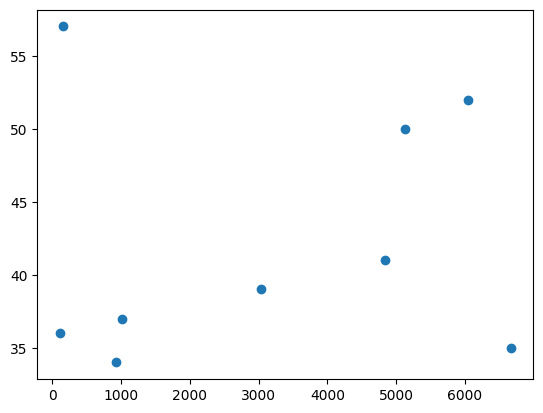

In [10]:
plt.scatter(pr, t_n)

In [11]:
'''Number of Technogenic and Natural in each year'''
t_n = []

#t_n.append(sum(df["t_2022"]+df["n_2022"]))
t_n.append(sum(df["t_2021"]+df["n_2021"]))
t_n.append(sum(df["t_2020"]+df["n_2020"]))
t_n.append(sum(df["t_2019"]+df["n_2019"]))
t_n.append(sum(df["t_2018"]+df["n_2018"]))
#t_n.append(sum(df["t_2017"]+df["n_2017"]))
t_n.append(sum(df["t_2016"]+df["n_2016"]))
t_n.append(sum(df["t_2015"]+df["n_2015"]))
t_n.append(sum(df["t_2014"]+df["n_2014"]))

'''Claim size'''

ips = [1.1189, 1.1261, 1.0565, 1.0207, 1.0446, 1.0267, 1.0515, 1.0881, 1.1173] # inflation in region 

pr = []

#pr.append(sum(df["pr_2022"])*math.prod(ips[8:]))
pr.append(sum(df["pr_2021"])*math.prod(ips[7:]))
pr.append(sum(df["pr_2020"])*math.prod(ips[6:]))
pr.append(sum(df["pr_2019"])*math.prod(ips[5:]))
pr.append(sum(df["pr_2018"])*math.prod(ips[4:]))
#pr.append(sum(df["pr_2017"])*math.prod(ips[3:]))
pr.append(sum(df["pr_2016"])*math.prod(ips[2:]))
pr.append(sum(df["pr_2015"])*math.prod(ips[1:]))
pr.append(sum(df["pr_2014"])*math.prod(ips))

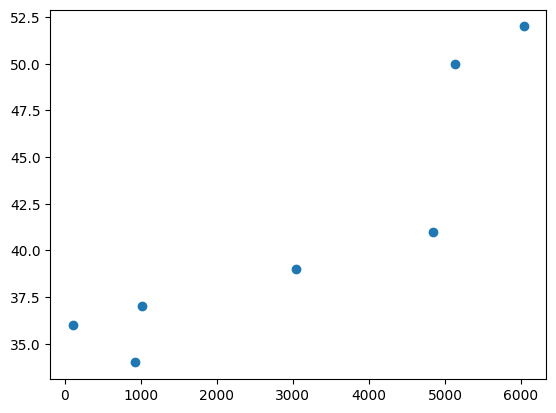

In [12]:
plt.scatter(pr, t_n)

In [13]:
'''average frequency for disaster in one year'''
np.mean(t_n) 

41.285714285714285

In [15]:
'''average claim size for one disaster'''
one_pr = [int(p) / int(t) for p,t in zip(pr, t_n)]
print(one_pr)
np.mean(one_pr)

[27.37837837837838, 102.64, 2.9722222222222223, 77.82051282051282, 27.205882352941178, 118.02439024390245, 116.07692307692308]


67.44547272784003

2024-05-23 01:27:24.343 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.133917)
2024-05-23 01:27:24.345 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.12525)
2024-05-23 01:27:24.350 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.132905)
2024-05-23 01:27:24.356 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.133821)
2024-05-23 01:27:24.374 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.13433)
2024-05-23 01:27:24.391 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.131203)
2024-05-23 01:27:24.433 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.132905)
2024-05-23 01:27:24.444 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted co

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
weibull_max,0.114955,1343.280433,1343.118163,inf,0.555502,0.014698
arcsine,0.122282,1017.960182,1017.852002,inf,0.217833,0.830088
genextreme,0.124136,1047.767428,1047.605159,inf,0.286186,0.523545
exponpow,0.124947,1420.578166,1420.415896,inf,0.774722,0.000062
powerlaw,0.125250,1154.346361,1154.184092,inf,0.636747,0.002760


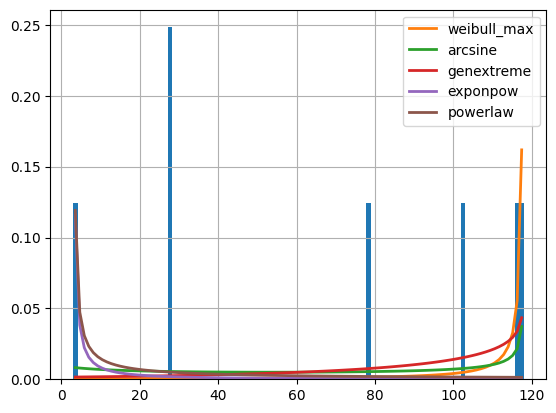

In [16]:
from fitter import Fitter, get_common_distributions


#Organize Data - from question
SR_y = pd.Series(one_pr, name="one_pr (Target Vector Distribution)")


# fitter
distributions_set = get_common_distributions()
distributions_set.extend(['arcsine', 'cosine', 'expon', 'weibull_max', 'weibull_min', 
                          'dweibull', 't', 'pareto', 'exponnorm', 'lognorm',
                          "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])  

f = Fitter(SR_y, distributions = distributions_set) 
f.fit()
f.summary()

In [17]:
f.fitted_param

{'norm': (67.44547272784003, 44.16032120240298),
 'expon': (2.9722222222222223, 64.4732505056178),
 'powerlaw': (0.159836975285734, 2.972222222222222, 115.05216802168023),
 'rayleigh': (-16.620987995922288, 67.14649576604602),
 'cauchy': (83.49679763371078, 34.937531144149524),
 'uniform': (2.9722222222222223, 115.05216802168022),
 'cosine': (66.23274560962749, 34.82098278491374),
 'arcsine': (-9.546180352250207, 127.57057059615266),
 'lognorm': (4.529421845109091, 2.9722222202627693, 1.6159310200776047),
 'chi2': (1.5540023723210734, 2.972222222222222, 32.02032931189348),
 'exponpow': (0.12782787586437291, 2.972222222222222, 4.187495761227419),
 'pareto': (0.16810784936887857, 2.912006619062498, 0.06021560315972429),
 'dweibull': (3.473756200109879, 60.82717757041979, 47.20085647192751),
 'gamma': (356.7755737336206, -771.5985192494054, 2.3516579896981717),
 'weibull_min': (1.6601607073024134, -7.853392991763429, 83.84218848540893),
 'exponnorm': (0.0009725652889808404, 67.40257736475

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


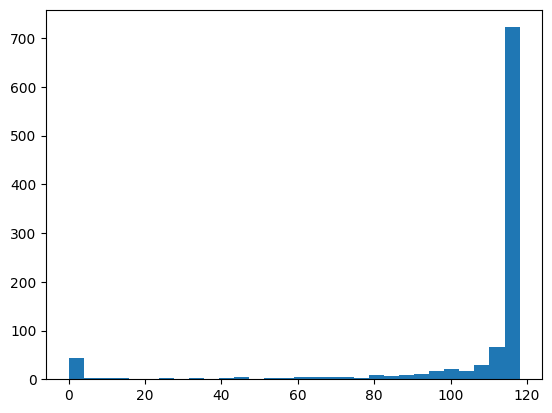

In [19]:
from scipy.stats import weibull_max

r = weibull_max.rvs(0.2601988233775363, 118.02439024390246, 1.4761629266527154, size=1000)

abs_r = []

for i in r:
    if i >= 0:
        abs_r.append(i)
    if i < 0:
        abs_r.append(0)
        
plt.hist(abs_r, bins=30, histtype="stepfilled")
#plt.set_xlim([x[0], x[-1]])
plt.legend(loc='best', frameon=False)
plt.show()

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

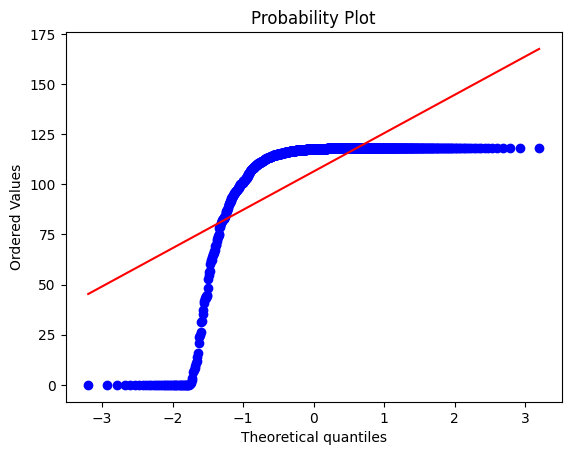

In [20]:
stats.probplot(abs_r, plot=plt)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


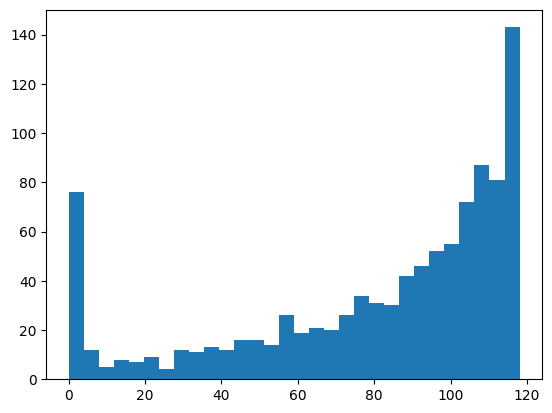

In [21]:
from scipy.stats import genextreme

r = genextreme.rvs(1.2281592464033961, 78.0892807337745, 49.046674000995836, size=1000)

abs_r = []

for i in r:
    if i >= 0:
        abs_r.append(i)
    if i < 0:
        abs_r.append(0)
        
plt.hist(abs_r, bins=30, histtype="stepfilled")
#plt.set_xlim([x[0], x[-1]])
plt.legend(loc='best', frameon=False)
plt.show()

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

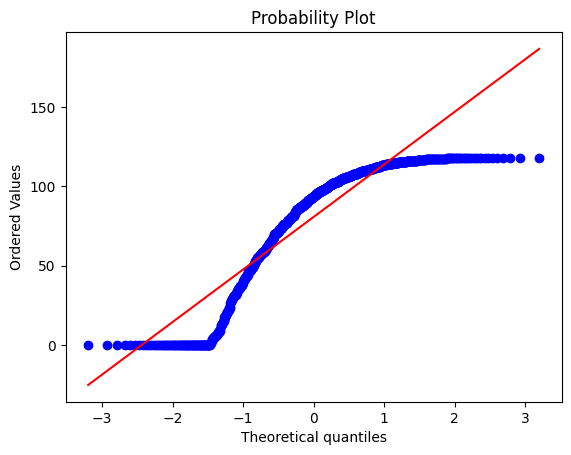

In [22]:
stats.probplot(abs_r, plot=plt)

# ALL years

In [23]:
claims = {}
for t in tqdm(years):
    claims_t = []
    for i in range(10000):
        rvs = poisson.rvs(41.285714285714285*t)*weibull_max.rvs(0.2601988233775363, 118.02439024390246, 1.4761629266527154)
        if rvs >= 0:
            claims_t.append(rvs)
        if rvs < 0:
            claims_t.append(0)
        claims[f'X_{t}'] = claims_t

100%|███████████████████████████████████████████| 61/61 [00:33<00:00,  1.83it/s]


In [24]:
sorted_claims = {k: sorted(v) for k, v in claims.items()}

In [26]:
cdf_all = pd.DataFrame(sorted_claims)
cdf_all

,X_0.0,X_0.08333333333333333,X_0.16666666666666666,X_0.25,X_0.3333333333333333,X_0.4166666666666667,X_0.5,X_0.5833333333333334,X_0.6666666666666666,X_0.75,...,X_4.25,X_4.333333333333333,X_4.416666666666667,X_4.5,X_4.583333333333333,X_4.666666666666667,X_4.75,X_4.833333333333333,X_4.916666666666667,X_5.0
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1280.292127,2004.148706,2596.028924,3083.798182,3585.794157,4354.611578,5099.803784,5426.995535,5901.017254,...,26195.470734,26666.159389,26791.534709,27503.756246,28089.563828,28310.808160,28915.946175,28891.068586,29268.457032,30443.702258
9996,0.0,1287.862536,2006.409146,2596.531531,3155.163521,3608.368076,4364.621558,5151.661130,5428.105153,5901.219040,...,26319.429768,26673.510722,27025.244574,27571.703811,28207.202190,28325.340471,29042.597866,28937.695690,29349.835935,30568.303421
9997,0.0,1320.672156,2006.413198,2620.683392,3172.440965,3656.547066,4366.759410,5182.408569,5429.116661,6018.805344,...,26436.947137,27027.540240,27246.790554,27719.834956,28321.467390,28355.461645,29102.148404,29032.491750,29387.624709,30795.912600
9998,0.0,1357.251498,2123.726956,2714.556881,3293.028293,3771.795923,4366.895677,5192.957038,5547.056071,6137.029875,...,26546.100883,27258.392116,27288.903939,28089.804878,28389.541865,28559.946088,29151.032430,29152.007648,29563.377662,30921.923307


In [27]:
def integrand(x):
    return a

prob = []

for i in range(1,10001):
    prob.append(i/10000)

for i in years:
    cdf_all[f'prob_{i}'] = prob
    
for i in years:
    cdf_all[f'prob_{i}'][(cdf_all[f'X_{i}']==0)] = 0

n= -1
for i in years:
    n+=1
    cdf_all[f'rate_{i}'] = rate[n]

n= -1
for i in years:
    n+=1
    a = rate[n]
    cdf_all[f'discount_{i}'] = math.exp(-quad(integrand, 0, i)[0])

for i in years:
    cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']

/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_21680/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_21680/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_21680/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [30]:
X_0 = []
Y_0 = []
Z_0 = []

for i in years:
    for n in cdf_all[f'X_{i}'].tolist():
        X_0.append(n)

for i in years:
    for n in cdf_all[f'V_{i}'].tolist():
        Y_0.append(n)

for i in years:
    for n in range(10000):
        Z_0.append(i)

In [32]:
X = X_0
Y = Y_0
Z = Z_0

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),np.linspace(np.min(Y),np.max(Y),10))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')


@interact(elev=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False), azim=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False))
def plot_3d(elev, azim):
    #Figure settings
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    #Display 3D graph
    ax.plot_surface(plotx,plotz,ploty,cstride=1,rstride=1,cmap='viridis')
    ax.set_xlabel('D (критический уровень триггера)') 
    ax.set_ylabel('T (срок, лет)') 
    ax.set_zlabel('V (Стоимость)')
    
    #Set the initial value of the viewing direction of the 3D graph
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interactive(children=(IntSlider(value=30, continuous_update=False, description='elev', max=180, min=-180, step…

In [33]:
# Expected loss 2%
s_2 = round(((1/cdf_all['V_2.0'][9800])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9800])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9800])**(1/4)-1-0.1192)*100, 3)

print('Expected loss 2%')
print(round(cdf_all['X_2.0'][9800], 3), round(cdf_all['X_3.0'][9800], 3), round(cdf_all['X_4.0'][9800], 3))
print(round(cdf_all['V_2.0'][9800], 4), round(cdf_all['V_3.0'][9800], 4), round(cdf_all['V_4.0'][9800], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 2,5%
s_2 = round(((1/cdf_all['V_2.0'][9750])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9750])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9750])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 2,5%')
print(round(cdf_all['X_2.0'][9750], 3), round(cdf_all['X_3.0'][9750], 3), round(cdf_all['X_4.0'][9750], 3))
print(round(cdf_all['V_2.0'][9750], 4), round(cdf_all['V_3.0'][9750], 4), round(cdf_all['V_4.0'][9750], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 3%
s_2 = round(((1/cdf_all['V_2.0'][9700])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9700])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9700])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 3%')
print(round(cdf_all['X_2.0'][9700], 3), round(cdf_all['X_3.0'][9700], 3), round(cdf_all['X_4.0'][9700], 3))
print(round(cdf_all['V_2.0'][9700], 4), round(cdf_all['V_3.0'][9700], 4), round(cdf_all['V_4.0'][9700], 4))
print(s_2, s_3, s_4)

Expected loss 2%
11802.397 17226.265 22393.76
0.7581 0.6672 0.5875
2.301 2.279 2.3

Expected loss 2,5%
11684.325 17101.731 22188.58
0.7542 0.6638 0.5845
2.595 2.474 2.446

Expected loss 3%
11601.141 16935.275 22069.55
0.7504 0.6604 0.5815
2.891 2.671 2.593
